## Step 1
### About the Dataset

Polaris ([polarishub.io](https://polarishub.io/datasets/asap-discovery/antiviral-potency-2025-unblinded)) is an open-source platform that provides high-quality datasets for machine learning in drug discovery.

The chosen dataset ([source](https://asapdiscovery.org/pipeline/)) contains 1,328 pIC50 values against both the MERS-CoV Mpro target and the SARS-CoV-2 Mpro target. I've chosen this as it is intended to reflect a realistic dataset used in drug discovery settings, unlike other sources such as the [MoleculeNet](https://moleculenet.org/) datasets, which have been criticised for their flaws (see [this blogpost](https://practicalcheminformatics.blogspot.com/2023/08/we-need-better-benchmarks-for-machine.html) by Pat Walters).

This dataset was used in a blind challenge, with the dataset split into training and test, which is labelled in the 'set' column. Here, I will hold out the test set entirely until after completing my cross-validation (CV) procedure. i.e. I will conduct my training and CV procedure on the datapoints labelled 'train', then will test the performance of the model on the 'test' datapoints.

Some issues have been highlighted with this dataset. In particular, some enantiomers were given the same SMILES strings, so even if they had different bioactivities, a machine learning model wouldn't be able to distinguish between the two. As such, I will filter out those cases when testing the model, as was done for the challenge.

In [1]:
from data.dataset import dataset_df

dataset_df

/Users/femisegvn/Coding/miniconda3/envs/antiviral-pot/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,CXSMILES,Molecule Name,Set,pIC50 (MERS-CoV Mpro),pIC50 (SARS-CoV-2 Mpro)
0,COC[C@]1(C)C(=O)N(C2=CN=CC3=CC=CC=C23)C(=O)N1C...,ASAP-0000141,Train,4.19,NaN
1,C=C(CN1CCC2=C(C=C(Cl)C=C2)C1C(=O)NC1=CN=CC2=CC...,ASAP-0000142,Train,4.92,5.29
2,CNC(=O)CN1C[C@]2(C[C@H](C)N(C3=CN=CC=C3C3CC3)C...,ASAP-0000143,Train,4.73,NaN
3,C=C(CN1CCC2=C(C=C(Cl)C=C2)C1C(=O)NC1=CN=CC2=CC...,ASAP-0000144,Train,4.90,6.11
4,C=C(CN1CCC2=C(C=C(Cl)C=C2)C1C(=O)NC1=CN=CC2=CC...,ASAP-0000145,Train,4.81,5.62
...,...,...,...,...,...
1323,O=C(CC1=CN=CC2=CC=CC=C12)N1CCCC[C@H]1[C@H]1CCC...,ASAP-0032561,Test,4.54,4.20
1324,O=C(CC1=CN=CC2=CC=CC=C12)N1CCCC[C@H]1[C@H]1CCC...,ASAP-0032562,Test,4.42,NaN
1325,O=C(CC1=CN=CC2=CC=CC=C12)N1CCC[C@H]2CCCC[C@@H]...,ASAP-0032572,Test,4.84,5.18
1326,COC1=CC=CC=C1[C@H]1C[C@H](C)CCN1C(=O)CC1=CN=CC...,ASAP-0032604,Test,5.53,5.59


## Step 2

### Data Preprocessing

As mentioned in the previous step, indistinct enantiomers need to be removed. Polaris noted entries `1036, 1039, 1219, 1225, 1306`, but I will verify that these are the only cases of such. Multiple SMILES strings can be used to represent the same molecule so I will canonicalise the smiles by transforming them into an `rdkit.mol` object and transforming that back into a SMILES string. I will be checking for other duplicate ent.

My cleaning process is as follows:
1. remove entries `1036, 1039, 1219, 1225, 1306`
2. canonicalise CXSMILES
3. Check for duplicates in training and test data 
    - if duplicates occur within the training set, merge them and use the mean of their pIC50 values
    - if duplicates occur in the test set ???
    - if a duplicate has one in the the training set and one in the test set, remove this entry entirely -- entries
    shouldn't be present in both the training and test set. Thankfully, we found no overlap between training and test

In [2]:
# First of all, I will remove the datapoints that Polaris as recommended to be removed from the dataset
dataset_df = dataset_df.drop([1036,1039,1219,1225,1306], axis=0)

In [3]:
# Here we canonicalise the smiles, ensuring a consistent systematic representation across all molecules
from utils import canonicalise_smiles
dataset_df.CXSMILES = canonicalise_smiles(dataset_df.CXSMILES)

In [4]:
# Checking for duplicates we see 172 rows of multiple instances of a CXSMILES
smiles = dataset_df.CXSMILES
duplicates = dataset_df[smiles.duplicated(keep=False)]
duplicates

,CXSMILES,Molecule Name,Set,pIC50 (MERS-CoV Mpro),pIC50 (SARS-CoV-2 Mpro)
37,C[C@H]1CC[C@@H]2C(=O)N(c3cncc4ccccc34)C(=O)N2C...,ASAP-0000180,Train,4.57,4.65
38,C[C@H]1CC[C@H]2C(=O)N(c3cncc4ccccc34)C(=O)N2C1...,ASAP-0000181,Train,4.69,4.37
39,C[C@H]1CC[C@@H]2C(=O)N(c3cncc4ccccc34)C(=O)N2C...,ASAP-0000182,Train,4.34,4.21
40,C[C@H]1CC[C@H]2C(=O)N(c3cncc4ccccc34)C(=O)N2C1...,ASAP-0000183,Train,4.76,NaN
69,CO[C@H]1CC[C@@H]2C(=O)N(c3cncc4ccccc34)C(=O)N2...,ASAP-0000228,Train,4.23,4.22
...,...,...,...,...,...
1322,O=C(Cc1cncc2ccccc12)N1CCCC[C@H]1[C@H]1CCCO1 |o...,ASAP-0032560,Test,4.33,4.02
1323,O=C(Cc1cncc2ccccc12)N1CCCC[C@H]1[C@H]1CCCO1 |o...,ASAP-0032561,Test,4.54,4.20
1324,O=C(Cc1cncc2ccccc12)N1CCCC[C@H]1[C@H]1CCCO1 |o...,ASAP-0032562,Test,4.42,NaN
1326,COc1ccccc1[C@H]1C[C@H](C)CCN1C(=O)Cc1cncc2cccc...,ASAP-0032604,Test,5.53,5.59


In [5]:
# Check the dataset to see if any SMILES in the training set are repeated in the test set
from utils import train_test_overlap
overlap = train_test_overlap(dataset_df)
overlap


set()

In [6]:
# Merge duplicate entries finding the mean of their pIC50s
from utils import merge_duplicates

dataset_df = merge_duplicates(dataset_df)

## Step 3

### Dataset Exploration

/Users/femisegvn/Chem/antiviral-potency/utils.py:414: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


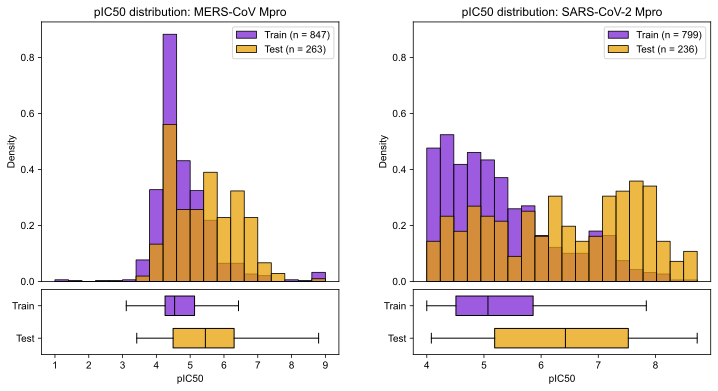

In [7]:
from utils import hist_plot
%config InlineBackend.figure_format = 'svg'
hist_plot(dataset_df)

#### A comment on the distributions

For both endpoints, the test set has a broader, more sparse distribution than the training set. This will challenge the predictive power of the model, as ML regressors tend to perform less well out of the training distribution.

Furthermore, the training data in both cases tends to have more negative skew than the the test data. Looking at the boxplots, the training sets have a median value closer to the lower quartile, and the lowere quartile much closer to the minimum than the upper quartile is to the maximum. I am defo gonna have to reword this because it is so unclear. On the other hand, the test sets have a median that falls pretty much exactly in the middle of the distribution, with a more symmetrical boxplot overall.

Given that the data is not normally distributed, it doesn't make sense to apply a standard scaler to this dataset. As recommended in the `scikit-learn` documentation, I will employ the `MaxAbsScaler` which is specifically designed for scaling sparse data.

/Users/femisegvn/Chem/antiviral-potency/utils.py:414: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


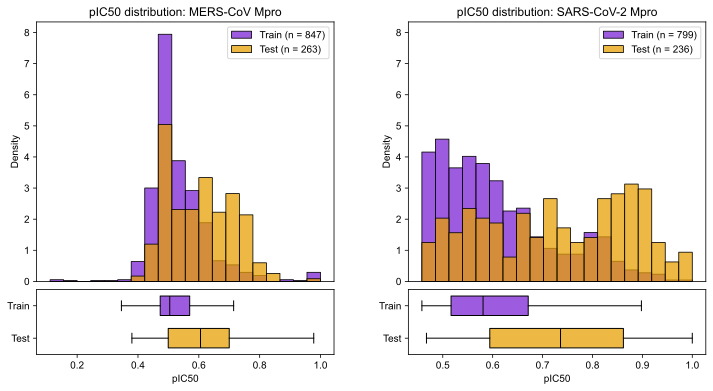

In [8]:
from sklearn.preprocessing import MaxAbsScaler
import numpy as np
mers_scaler = MaxAbsScaler()
sars_scaler = MaxAbsScaler()

mers_pIC50 = np.array(dataset_df['pIC50 (MERS-CoV Mpro)']).reshape(-1, 1)
sars_pIC50 = np.array(dataset_df['pIC50 (SARS-CoV-2 Mpro)']).reshape(-1, 1)

dataset_df['pIC50 (MERS-CoV Mpro) scaled'] = mers_scaler.fit_transform(mers_pIC50)
dataset_df['pIC50 (SARS-CoV-2 Mpro) scaled'] = sars_scaler.fit_transform(sars_pIC50)

hist_plot(dataset_df, mers_col = "pIC50 (MERS-CoV Mpro) scaled",
          sars_col = "pIC50 (SARS-CoV-2 Mpro) scaled")

#### Transformed Distributions
The distributions look pretty much identical but now all the values are between 0 and 1, and as a consequence the density of values is much higher. This could be more suitable for training a neural network however, having tried both without and with the scaled values, I don't think there's any significant benefit to either approach.

## Step 4

### Model Training and Cross Validation

In [9]:
train = dataset_df[dataset_df.Set == "Train"]
test = dataset_df[dataset_df.Set == "Test"]

mers_train = train[["CXSMILES", "pIC50 (MERS-CoV Mpro) scaled"]].dropna()
mers_test = test[["CXSMILES", "pIC50 (MERS-CoV Mpro) scaled"]].dropna()

sars_train = train[["CXSMILES", "pIC50 (SARS-CoV-2 Mpro) scaled"]].dropna()
sars_test = test[["CXSMILES", "pIC50 (SARS-CoV-2 Mpro) scaled"]].dropna()


### MERS Model
Featurisation with `featurise()`
Model training and benchmarking with a 5 x 5 CV procedure.

In [10]:
from utils import featurise, cross_validation
from rdkit import Chem
import numpy as np

mols = [Chem.MolFromSmiles(s) for s in mers_train.CXSMILES]
X = featurise(mols, scheme='rdkit_desc')
y = np.asarray(mers_train["pIC50 (MERS-CoV Mpro) scaled"], dtype = float)

fold_metrics = cross_validation(X, y, model="MLP", endpoint_scaler=mers_scaler, verbose =True)

5x5 CV Results:
R^2 : mean=0.109  std=0.082
MAE : mean=0.548  std=0.041
MSE: mean=0.709  std=0.133


### SARS Model

Featurisation with `featurise()`, followed by training and benchmarking with a 5 x 5 CV procedure

In [11]:
from utils import featurise, cross_validation
import numpy as np

mols = [Chem.MolFromSmiles(s) for s in sars_train.CXSMILES]
X = featurise(mols, scheme="rdkit_desc")
y = np.asarray(sars_train["pIC50 (SARS-CoV-2 Mpro) scaled"], dtype = float)

fold_metrics = cross_validation(X, y, model="MLP", endpoint_scaler=sars_scaler, verbose=True)


5x5 CV Results:
R^2 : mean=0.383  std=0.094
MAE : mean=0.632  std=0.038
MSE: mean=0.617  std=0.093


## Step 5

### Performance

Conduct one training cycle on the full training set and predict on the test set

### MERS Model Test

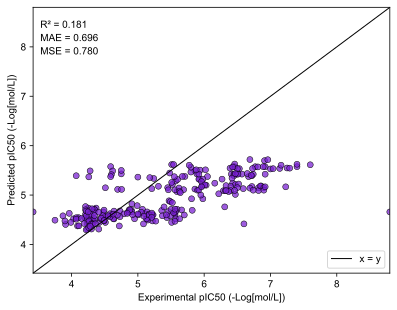

In [12]:
from utils import featurise, test_model, scatter_plot

train_mols = [Chem.MolFromSmiles(s) for s in mers_train.CXSMILES]
test_mols = [Chem.MolFromSmiles(s) for s in mers_test.CXSMILES]

X_train = featurise(train_mols, scheme = "rdkit_desc")
X_test = featurise(test_mols, scheme = "rdkit_desc")

y_train = np.asarray(mers_train["pIC50 (MERS-CoV Mpro) scaled"], dtype = float)
y_test = np.asarray(mers_test["pIC50 (MERS-CoV Mpro) scaled"], dtype = float)

test, pred = test_model(X_train, X_test, y_train, y_test, model = "MLP", endpoint_scaler=mers_scaler)

scatter_plot(test, pred)

### SARS Model Test

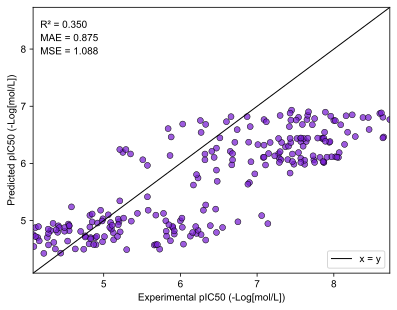

In [13]:
from utils import featurise, test_model, scatter_plot

train_mols = [Chem.MolFromSmiles(s) for s in sars_train.CXSMILES]
test_mols = [Chem.MolFromSmiles(s) for s in sars_test.CXSMILES]

X_train = featurise(train_mols, scheme = "rdkit_desc")
X_test = featurise(test_mols, scheme = "rdkit_desc")

y_train = np.asarray(sars_train["pIC50 (SARS-CoV-2 Mpro) scaled"], dtype = float)
y_test = np.asarray(sars_test["pIC50 (SARS-CoV-2 Mpro) scaled"], dtype = float)

test, pred = test_model(X_train, X_test, y_train, y_test, model = "MLP", endpoint_scaler=sars_scaler)

scatter_plot(test, pred)

## Step 6

### Feature engineering
In general, will try a few different approaches;
1. Morgan Fingerprint
2. RDKit descriptors (excluding fragments)
3. RDKit Fragments
4. Hybrid approach: A combination of all the above

I will first compare the performance of each of these approaches, then use the best performing model + descriptor combination to decide what model on which to conduct hyperparameter optimisation.


#### Selecting RDKit Descriptors

`rdkit.Chem.Descriptors.CalcMolDescriptors` calculates 217 descriptors - 132 are 2D numerical descriptors and the remaining 85 are discrete numeric fragment counts. When i've tried to throw all 217 descriptors in as features, I get ridiculous results, so I have chosen to treat the numerical descriptors and fragments counts as separate featurisation schemes. In the case of the fragment counts, I will just leave these as is -- i think the descriptors that aren't linked to the endpoints are less likely to significantly impact model performance. For the 132 2D descriptors however, I have decided to conduct an f-test to determine which descriptors are most closely linked to the endpoints, such that I can hopefully get some reasonable model performance. Here we go!

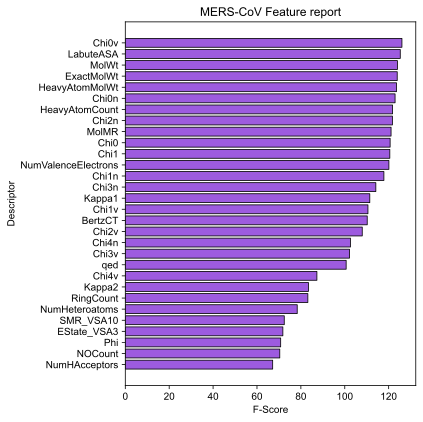

In [14]:
import rdkit.Chem as Chem
from utils import rdkit_all_desc_featuriser, select_features, feature_report

smiles = mers_train.CXSMILES
mols = [Chem.MolFromSmiles(s) for s in smiles]
X = rdkit_all_desc_featuriser(mols)
y = mers_train["pIC50 (MERS-CoV Mpro) scaled"]
X, report = select_features(X, y)

feature_report(report, title = "MERS-CoV Feature report")


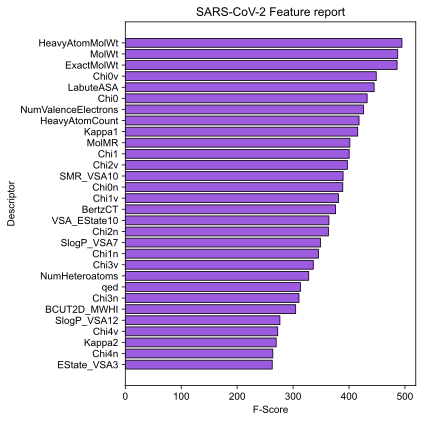

In [15]:
smiles = sars_train.CXSMILES
mols = [Chem.MolFromSmiles(s) for s in smiles]
X = rdkit_all_desc_featuriser(mols)
y = sars_train["pIC50 (SARS-CoV-2 Mpro) scaled"]
X_sel, report = select_features(X, y)
feature_report(report, title = "SARS-CoV-2 Feature report")

Given that these are very similar for both endpoints, and that some of these are likely to be very correlated, I will be using the following descriptors:

- qed
- MolWt (most significant of all molwt variants)
- NumValenceElectrons
- BertzCT
- Chi0v (most significant of all Chi parameters with both endpoints)
- Kappa1 (most significant out of Kappa1 and Kappa2)
- LabuteASA ...
- SMR_VSA10 ...
- Estate_VSA3 ...
- NumHeteroatoms
- MolMR



tbh to avoid those that are highly correlated I could definitely implement some correlation screener

### Comparison

Comparing the performance MLPs and XGBoost using each of the above approaches (Fingerprint, Numerical Descriptors, fragments, hybrid). Performance compared based on a correlation metric (R^2) and an error metric (MSE)

In [16]:
import pandas as pd

schemes = ["morgan_fp", "rdkit_desc", "rdkit_frags", "hybrid"]
targets = {"MERS": [mers_train, mers_scaler, "pIC50 (MERS-CoV Mpro) scaled"],
           "SARS": [sars_train, sars_scaler, "pIC50 (SARS-CoV-2 Mpro) scaled"]}
models = ["MLP", "xgboost"]

results_dfs = []

for target in targets.keys():
    results = []

    train, scaler, scaled_col = targets[target]
    mols = [Chem.MolFromSmiles(s) for s in train.CXSMILES]

    for scheme in schemes:

        for model in models:
            X = featurise(mols, scheme = scheme)
            y = np.asarray(train[scaled_col], dtype = float)
            fold_metrics = cross_validation(X, y, model=model, endpoint_scaler=scaler)
                
            for fold in fold_metrics:
                r2 = fold['r2']
                mae = fold['mae']
                result = {"scheme": scheme, "model": model, "r2": r2, "mae": mae}
                results.append(result)

    results_dfs.append(pd.DataFrame(results))



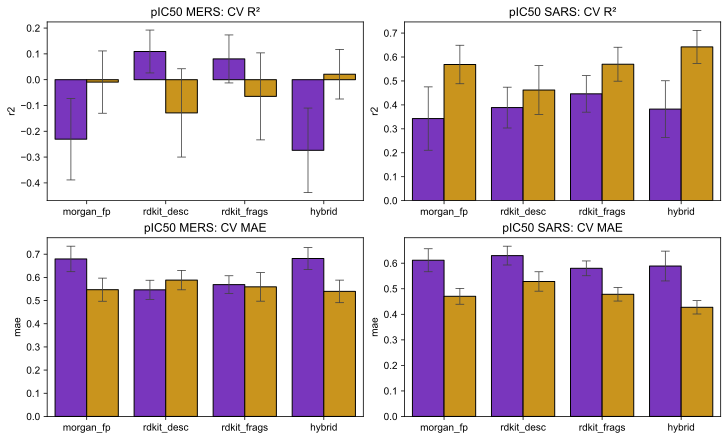

In [17]:
from utils import bar_plot

mers_results, sars_results = results_dfs

bar_plot(mers_results, sars_results, save_to="./images/CV.svg")

### Hyperparameter optimisation

Based on the above comparison which summarises my entire exploration, I will choose to optimise the hyperparameters of the xgboost model using the hybrid featurisation scheme

I will use the `hyperopt` package for hyperparameter optimisation. I will be optimising the following hyperparameters, as suggested by [this](https://www.researchgate.net/profile/Sayan-Putatunda/publication/331419832_A_Comparative_Analysis_of_Hyperopt_as_Against_Other_Approaches_for_Hyper-Parameter_Optimization_of_XGBoost/links/646836099533894cac7e9aa3/A-Comparative-Analysis-of-Hyperopt-as-Against-Other-Approaches-for-Hyper-Parameter-Optimization-of-XGBoost.pdf) paper.

In [16]:
import numpy as np
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, space_eval
from sklearn.model_selection import RepeatedKFold
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

mols = [Chem.MolFromSmiles(s) for s in mers_train.CXSMILES]
X = featurise(mols, scheme="rdkit_desc")
y = np.asarray(mers_train["pIC50 (MERS-CoV Mpro) scaled"], dtype = float)

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state = 0)

search_space = {"n_estimators": hp.choice("n_estimators", [300, 600, 1000, 1500, 2000]),
                "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.2)),
                "colsample_bytree": hp.uniform("colsample_bytree", 0.6, 1.0),
                "reg_lambda": hp.loguniform("reg_lambda", np.log(1e-2), np.log(10.0)),
                "max_depth": hp.choice("max_depth", [3, 4, 5, 6, 7, 8]),
                "subsample": hp.uniform("subsample", 0.6, 1.0)}
                #min_child_weight
                #gamma


def objective(params):
    model = XGBRegressor(objective="reg:squarederror",
                         tree_method = "hist",
                         random_state = 0, 
                         n_jobs = 1,
                         **params)
    
    maes = []

    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        feature_scaler = MaxAbsScaler()
        X_train = feature_scaler.fit_transform(X_train)
        X_test = feature_scaler.transform(X_test)

        model.fit(X_train, y_train)
        pred = model.predict(X_test)

        maes.append(mean_absolute_error(y_test, pred))
    
    loss = float(np.mean(maes))
    return {"loss": loss, "status": STATUS_OK}


trials = Trials()

opt = fmin(fn=objective,
            space=search_space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials,
            rstate=np.random.default_rng(0))


opt_params = space_eval(search_space, opt)
print(opt_params)

/Users/femisegvn/Coding/miniconda3/envs/antiviral-pot/lib/python3.11/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


100%|██████████| 100/100 [10:36<00:00,  6.37s/trial, best loss: 0.05819381096973698]
{'colsample_bytree': 0.6280040769047396, 'learning_rate': 0.010871530996119387, 'max_depth': 6, 'n_estimators': 300, 'reg_lambda': 9.610089776829183, 'subsample': 0.6237591758411857}


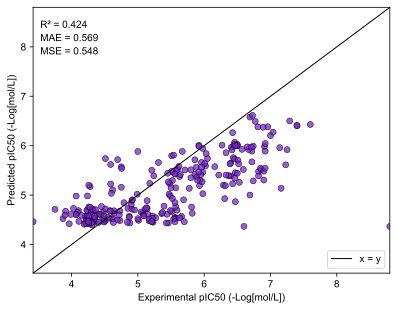

In [17]:
opt_model = XGBRegressor(objective="reg:squarederror", tree_method = "hist", random_state = 0,
                         n_jobs = -1, **opt_params)

train_mols = [Chem.MolFromSmiles(s) for s in mers_train.CXSMILES]
test_mols = [Chem.MolFromSmiles(s) for s in mers_test.CXSMILES]

X_train = featurise(train_mols, scheme = "hybrid")
X_test = featurise(test_mols, scheme = "hybrid")

y_train = np.asarray(mers_train["pIC50 (MERS-CoV Mpro) scaled"], dtype = float)
y_test = np.asarray(mers_test["pIC50 (MERS-CoV Mpro) scaled"], dtype = float)

feature_scaler = MaxAbsScaler()
X_train = feature_scaler.fit_transform(X_train)
X_test = feature_scaler.transform(X_test)

opt_model.fit(X_train, y_train)
pred = opt_model.predict(X_test)

pred = mers_scaler.inverse_transform(pred.reshape(-1, 1))
test = mers_scaler.inverse_transform(y_test.reshape(-1, 1))

scatter_plot(test, pred, "images/MERS-CoV_Test.svg")



In [18]:
import numpy as np
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, space_eval
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

mols = [Chem.MolFromSmiles(s) for s in sars_train.CXSMILES]
X = featurise(mols, scheme="hybrid")
y = np.asarray(sars_train["pIC50 (SARS-CoV-2 Mpro) scaled"], dtype = float)

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state = 0)

search_space = {"n_estimators": hp.choice("n_estimators", [300, 600, 1000, 1500, 2000]),
                "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.2)),
                "colsample_bytree": hp.uniform("colsample_bytree", 0.6, 1.0),
                "reg_lambda": hp.loguniform("reg_lambda", np.log(1e-2), np.log(10.0)),
                "max_depth": hp.choice("max_depth", [3, 4, 5, 6, 7, 8]),
                "subsample": hp.uniform("subsample", 0.6, 1.0)}
                #min_child_weight
                #gamma

def objective(params):
    model = XGBRegressor(objective="reg:squarederror",
                         tree_method = "hist",
                         random_state = 0, 
                         n_jobs = 1,
                         **params)
    
    maes = []

    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        feature_scaler = MaxAbsScaler()
        X_train = feature_scaler.fit_transform(X_train)
        X_test = feature_scaler.transform(X_test)

        model.fit(X_train, y_train)
        pred = model.predict(X_test)

        maes.append(mean_absolute_error(y_test, pred))
    
    loss = float(np.mean(maes))

    return {"loss": loss, "status": STATUS_OK}


trials = Trials()

opt = fmin(fn=objective,
            space=search_space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials,
            rstate=np.random.default_rng(0))


opt_params = space_eval(search_space, opt)
print(opt_params)

100%|██████████| 100/100 [2:16:04<00:00, 81.65s/trial, best loss: 0.045506054365873315]  
{'colsample_bytree': 0.6633806894423597, 'learning_rate': 0.025010580574185825, 'max_depth': 6, 'n_estimators': 2000, 'reg_lambda': 3.339613643927052, 'subsample': 0.6460025531061554}


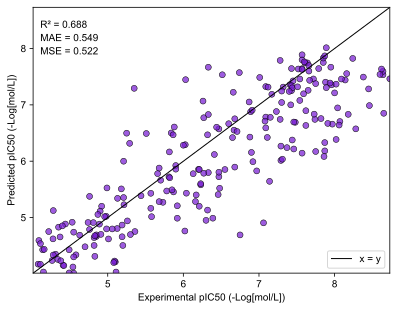

In [19]:
opt_model = XGBRegressor(objective="reg:squarederror", tree_method = "hist", random_state = 0,
                         n_jobs = -1, **opt_params)

train_mols = [Chem.MolFromSmiles(s) for s in sars_train.CXSMILES]
test_mols = [Chem.MolFromSmiles(s) for s in sars_test.CXSMILES]

X_train = featurise(train_mols, scheme = "hybrid")
X_test = featurise(test_mols, scheme = "hybrid")

y_train = np.asarray(sars_train["pIC50 (SARS-CoV-2 Mpro) scaled"], dtype = float)
y_test = np.asarray(sars_test["pIC50 (SARS-CoV-2 Mpro) scaled"], dtype = float)

feature_scaler = MaxAbsScaler()
X_train = feature_scaler.fit_transform(X_train)
X_test = feature_scaler.transform(X_test)

opt_model.fit(X_train, y_train)
pred = opt_model.predict(X_test)

pred = sars_scaler.inverse_transform(pred.reshape(-1, 1))
test = sars_scaler.inverse_transform(y_test.reshape(-1, 1))

scatter_plot(test, pred, save_to='images/SARS-CoV-2_Test.svg')

### Note for Gabriele

I am aware that the assignment only requested *one* machine learning model, and that the focus should be on the featurisation methods. However, I started using an MLP and I was losing my mind trying to incorporate various rdkit descriptors, finding that nothing was working on this dataset. When I switched to XGBoost, it seemed to respond much better to the rdkit descriptors, and I couldn't help but include data on the rigamarole that I went through with the MLPs, so that data is included here for completeness. If you must, feel free to ignore any discussion including the MLPs and mark my assignment only on the work with xgboost. Regardless, thank you for setting this assignment, I learnt a lot and had plenty fun. 